![Alt text: Slogan da Meteora.](https://i.imgur.com/VDYh2G1.png)

In [50]:
#importando as bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, inspect, text, MetaData , Table

# 1. Estruturando a tabela

**Meteora** é uma loja que vende roupas e acessórios de diversas marcas por todos os estados do Brasil, para entender suas bases de dados e exibir informações relevantes com o objetivo de auxiliar suas tomadas de decisão.

**Sobre as tabelas**

* itens_pedidos: tabela que informa sobre o que foi vendido, vai ter informação o preço, quantidade, para onde vai ser enviado e o frete do pedido
* pedidos: vai falar sobre a venda feita, tendo informação sobre os vendedores, preço do pedido e a data da venda
* produtos: informa características dos produtos que são comercializados na loja
* vendedores: informa o nome dos vendedores.

In [12]:
url_itens_pedidos = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/itens_pedidos.csv'
url_pedidos = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/pedidos.csv'
url_produto = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/produtos.csv'
url_vendedores = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/vendedores.csv'

In [37]:
#Lendo e atribuindo as tabelas para as variaveis criada abaixo
itens_pedidos = pd.read_csv(url_itens_pedidos)
pedidos = pd.read_csv(url_pedidos)
produtos = pd.read_csv(url_produto)
vendedores = pd.read_csv(url_vendedores)


In [16]:
#fazendo um banco de dados local
engine = create_engine('sqlite:///:memory:')

In [ ]:
#adicionando as tabelas no banco de dados e desabilitando o index
produtos.to_sql('produtos', engine,index=False)
pedidos.to_sql('pedido', engine,index=False)
itens_pedidos.to_sql('itens_pedidos', engine,index=False)
vendedores.to_sql('vendedores', engine,index=False)

In [52]:
#Verificando se as tabelas foram adicionadas
inspector = inspect(engine)
print(inspector.get_table_names())

['itens_pedidos', 'pedido', 'produtos', 'vendedores']


# 2. Primeiras consultas

Vamos entender a característica do produto que é comercializadora na Meteora, analisando a **condição** dos produtos vendidos.

In [21]:
#Criando uma string para fazer
query = 'SELECT CONDICAO FROM PRODUTOS'

Codigo utilizando pandas e dataframe

pd.DataFrame(produtos['Condicao'])


In [22]:
#fazendo a condição da engine com nossa query
with engine.connect() as conexao:
    #consulta vai receber o resultado da consulta
    consulta = conexao.execute(text(query))
    #coletando todas os dados da consulta e armazenando
    dados = consulta.fetchall()

#criando o dataframe da consulta
pd.DataFrame(dados,columns=consulta.keys())

,Condicao
0,Usado
1,Usado
2,Usado
3,Usado
4,Usado
...,...
200,Usado
201,Usado
202,Usado
203,Usado


In [23]:
#criando uma função para fazer as consulta e gerar um dataframe da consulta
def sql_df(query):
    #fazendo a condição da engine com nossa query
    with engine.connect() as conexao:
        #consulta vai receber o resultado da consulta
        consulta = conexao.execute(text(query))
        #coletando todas os dados da consulta e armazenando
        dados = consulta.fetchall()
    #criando o dataframe da consulta
    return pd.DataFrame(dados,columns=consulta.keys())


In [32]:
query = '''SELECT CONDICAO,COUNT(*) AS Quantidade
FROM PRODUTOS
GROUP BY CONDICAO;'''

df_produtos = sql_df(query)
df_produtos

,Condicao,Quantidade
0,Novo com etiqueta,22
1,Novo sem etiqueta,7
2,Usado,176


Codigo utilizando pandas e dataframe
produtos.groupby('Condicao').size().reset_index(name='Quantidade')


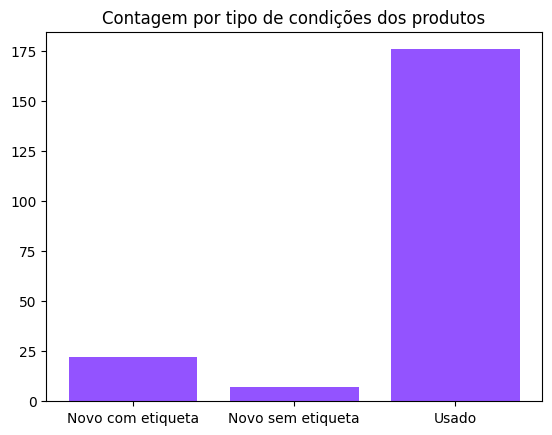

In [34]:
#criando uma visualização
plt.bar(df_produtos['Condicao'], df_produtos['Quantidade'], color = '#9353FF')
plt.title('Contagem por tipo de condições dos produtos')
plt.show()

Agora precisamos ranquear os produtos que mais foram pedidos por **quantidade** para entender a necessidade de um estoque de produtos na loja.

In [35]:
sql_df ('SELECT * FROM PRODUTOS').head(3)

,produto_id,produto,preco,marca,sku,Condicao
0,21244,Oculos Lente Azulada,1120,D&g Dolce & Gabbana,209297,Usado
1,9981,Bolsa Coral Saco,4000,Givenchy,278612,Usado
2,84176,Camisa Xadrez Verde,310,Joe Fresh,322482,Usado


In [53]:
sql_df('SELECT * FROM ITENS_PEDIDOS').head(3)

,id_nf,produto_id,pedido_id,quantidade,valor_unitario,valor_total,Estado,frete
0,1,41518,341,3,260,780,BR-BA,156.0
1,2,4307,1174,5,6175,30875,BR-RJ,6175.0
2,3,22407,1399,3,200,600,BR-PB,120.0


Codigo pandas
produtos.head(3)

itens_pedidos.head(3)


In [66]:
query = '''SELECT ITENS_PEDIDOS.PRODUTO_ID, PRODUTOS.PRODUTO, 
SUM(ITENS_PEDIDOS.QUANTIDADE) AS Quantidade   
FROM  PRODUTOS, ITENS_PEDIDOS
WHERE ITENS_PEDIDOS.PRODUTO_ID = PRODUTOS.PRODUTO_ID
GROUP BY PRODUTOS.PRODUTO
ORDER BY Quantidade ASC'''

df_prod_qtd= sql_df(query)
df_prod_qtd

,produto_id,produto,Quantidade
0,47682,Vestido Malha Estampa,318
1,84743,Blusa Listrada Malha,322
2,88368,Blusa Malha Azul,325
3,32986,Blusa Babados Off-white,337
4,2706,Blusa Cinza,341
...,...,...,...
196,32126,Saia Midi Cinto,549
197,47475,Calca Alfaiataria Preta,750
198,75557,Saia Pregas Preta,751
199,44424,Calca Jeans Costuras,755


Código em pandas
df_prod_quant = itens_pedidos.merge(produtos, on='produto_id')

df_prod_quant = df_prod_quant.groupby('produto')['quantidade'].sum().reset_index()

df_prod_quant = df_prod_quant.sort_values('quantidade', ascending=True).reset_index(drop=True)

df_prod_quant


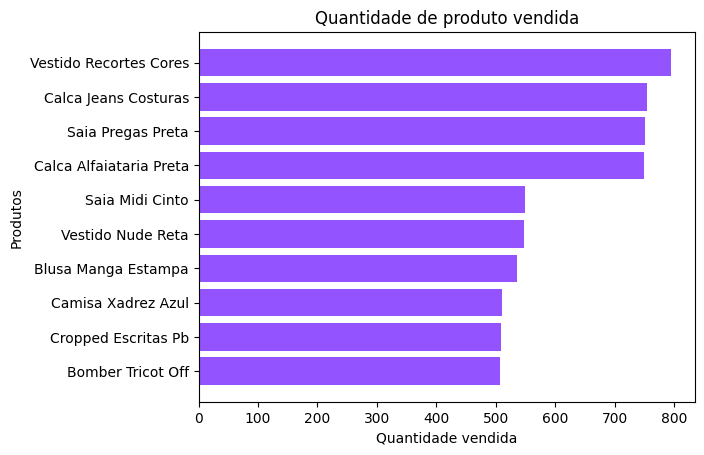

In [68]:
plt.barh(df_prod_qtd['produto'][-10:], df_prod_qtd['Quantidade'][-10:], color='#9353FF')
plt.title('Quantidade de produto vendida')
plt.xlabel('Quantidade vendida')
plt.ylabel('Produtos')
plt.show()

# 3. Lidando com filtro

Vamos iniciar uma análise de desempenho do **time de vendedores** da Meteora. A intenção aqui é entender como se deram as vendas dos vendedores no **ano anterior** para que possam ser aplicadas promoções e bônus salarial para a equipe no ano atual da tabela que é 2021

Para entender o desempenho de vendas dos vendedores no ano de 2020, é preciso trabalhar com os dados que estão presentes apenas no ano de 2020.

# 4. Avançando nas relações

A Meteora agora deseja incrementar as suas vendas no **estado de São Paulo (SP)**, por acreditar ser uma região mais propícia às vendas já que tem uma boa concentração de pessoas e mercado também.

Mas será que São Paulo já não rende muitas vendas em relação a outros estados?

Uma das ações que a Meteora pretende seguir para as vendas em SP é escolher dois de seus vendedores para que eles **foquem suas vendas** lá. Para essa escolha é interessante ter os profissionais que **mais tenham vendido** para as pessoas da região.